# **Title: stock-news-sentiment-finbert-lora**
#### *Authors: **Team Avengers**: Raghu Ram Komara, Sai Pratap Kodidasu, Naveen Pogiri*

> - [Course Name : ISM6561- Deep Learning]  
> - [Team Members : Raghu Ram Komara, Sai Pratap Kodidasu, Naveen Pogiri]  
> - [Due Date : 04-24-2025]

###**Install Required Python Packages**

This cell installs all of the core libraries and pins them to known-good versions to ensure compatibility:

- **`torch==2.0.1`** – PyTorch 2.0.1, the deep learning framework for defining and training our models.  
- **`transformers==4.34.0`** – Hugging Face’s Transformers library, which provides pre-trained models and tokenizers.  
- **`datasets==2.14.5`** – Hugging Face’s Datasets library, for loading, processing, and splitting our datasets.  
- **`accelerate==0.23.0`** – Hugging Face Accelerate to simplify multi-GPU or mixed-precision training.  
- **`peft==0.5.0`** – Parameter-Efficient Fine-Tuning (PEFT) tools, such as LoRA adapters.  
- **`tqdm`** – A lightweight progress-bar utility for monitoring loops.  
- **`pandas`** – Data loading and manipulation with DataFrames.  
- **`scikit-learn`** – Classic machine-learning utilities, especially for evaluation metrics (accuracy, F1, confusion matrix, etc).

By pinning the versions, we avoid unexpected breaking changes when running this notebook.  


In [1]:
# First, upload your requirements.txt (if it isn’t already in the working directory)
from google.colab import files
uploaded = files.upload()   # choose your requirements.txt from the file picker

# Then install:
!pip install -r requirements.txt

Saving requirements.txt to requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━

### **Environment Setup, Reproducibility & Device Selection**

This cell performs three essential preparation steps:

- **Importing Libraries**  
  Brings in all the external packages needed for data loading, model/tokenizer setup, parameter-efficient fine-tuning, batching, optimization, evaluation metrics, and progress monitoring.

- **Fixing Random Seeds**  
  Ensures that every run uses the same random initialization and data shuffling by seeding Python’s, NumPy’s, and PyTorch’s random number generators (including GPU).

- **Determining Compute Device**  
  Automatically detects and reports whether a CUDA-capable GPU is available (and uses it) or falls back to CPU, so that all subsequent tensors and models are moved to the correct device.


In [1]:
import random
import numpy as np
import torch
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, PeftModel

from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm

# 1) Set seed for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2) Select device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Using device: cuda


### **Data Loading, Prompt/Label Formatting & Train/Val/Test Split**

This cell covers the following steps:

1. **Raw Data Ingestion**  
   - Loads the CSV of stock‐news headlines into a Hugging Face Dataset.

2. **Prompt–Label Construction**  
   - Transforms each example into a two‐field format:  
     - **`prompt`**, which contains a fixed instruction plus the headline text.  
     - **`label`**, which maps the numeric sentiment code (0/1/2) to a human‐readable class (`negative`/`positive`/`neutral`).  
   - Drops all original columns to ensure the model only sees “prompt” at training time (no label leakage).

3. **Dataset Splitting**  
   - **Test Set**: Carves off 10% of the data for final evaluation.  
   - **Validation Set**: From the remaining 90%, samples ~11.11% (i.e. 10% of the original) for tuning and early stopping.  
   - **Training Set**: The rest (~80% of the original) used for model fitting.  

4. **Sanity Check**  
   - Prints the sizes of the training, validation, and test splits to confirm the proportions.


In [2]:
# 1. Load raw CSV
raw_ds = load_dataset("csv", data_files="/content/stock_news.csv")["train"]

# 2. Split into `prompt` (model input) & `label` (target) to avoid leakage
def format_instruction_stock(example):
    label_map = {0: "negative", 1: "positive", 2: "neutral"}
    prompt = (
        "### Instruction:\n"
        "Classify the sentiment of this stock news headline.\n\n"
        "### Input:\n"
        f"{example['headline']}\n\n"
        "### Response:"
    )
    label = label_map.get(example["label"], str(example["label"]))
    return {"prompt": prompt, "label": label}

# remove all old columns so only prompt+label remain
ds = raw_ds.map(format_instruction_stock, remove_columns=raw_ds.column_names)

# 3. First split off TEST (10%)
split1      = ds.train_test_split(test_size=0.10, seed=42)
train_val_ds, test_ds = split1["train"], split1["test"]

# 4. Then carve out VAL (≈10% of total → 11.11% of the 90%)
split2     = train_val_ds.train_test_split(test_size=0.111111, seed=42)
train_ds, val_ds = split2["train"], split2["test"]

print(f"Train size:      {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size:       {len(test_ds)}")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/26000 [00:00<?, ? examples/s]

Train size:      20800
Validation size: 2600
Test size:       2600


### **Tokenizer Setup and Configuration**

1. **Load the Pre-trained Tokenizer**  
   - Retrieves the tokenizer for the chosen model (`ProsusAI/finbert`) from the Hugging Face Hub.

2. **Define a Padding Token If Missing**  
   - Many causal (decoder-only) tokenizers don’t include a pad token by default.  
   - Assigns the end-of-sequence (EOS) token as the pad token to enable batch padding.

3. **Enforce Left-Padding**  
   - Sets `padding_side = "left"` so that shorter sequences are padded on the left, preserving causal attention semantics.

4. **Print Configuration**  
   - Displays the pad token, pad token ID, and padding direction to confirm correct tokenizer setup.  


In [7]:
# Load & configure the tokenizer
from transformers import AutoTokenizer

model_id = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

# Ensure a pad token exists (FinBERT is a BERT variant and already has one,
# but this covers edge cases)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# For encoder‐only models like BERT/FinBERT, right‐padding is the standard
tokenizer.padding_side = "right"

print("Tokenizer loaded:")
print(f"  • Model ID:       {model_id}")
print(f"  • Pad token:      {tokenizer.pad_token}")
print(f"  • Pad token ID:   {tokenizer.pad_token_id}")
print(f"  • Padding side:   {tokenizer.padding_side}")

Tokenizer loaded:
  • Model ID:       ProsusAI/finbert
  • Pad token:      [PAD]
  • Pad token ID:   0
  • Padding side:   right


### **Tokenization & DataLoader Preparation**

This cell converts your raw `prompt`/`label` pairs into numerical inputs for FinBERT and builds PyTorch DataLoaders:

1. **Label Mapping**  
   - Defines `label2id = {"negative": 0, "positive": 1, "neutral": 2}` to translate human-readable classes into integer IDs.

2. **Tokenization Function**  
   - `tokenize_for_classification(batch)`  
     - Pads/truncates each `batch["prompt"]` to a fixed `max_length` (256 tokens).  
     - Converts string labels to lowercase and maps them to integer IDs (`tok["labels"]`).

3. **Apply to Dataset Splits**  
   - Runs `train_ds.map(...)`, `val_ds.map(...)`, and `test_ds.map(...)` with `batched=True`, removing original columns so only tokenized fields remain.

4. **Dataset Wrapper**  
   - Defines `SequenceClassificationDataset`, a `torch.utils.data.Dataset` subclass that returns a dict of  
     - `input_ids` (LongTensor)  
     - `attention_mask` (LongTensor)  
     - `labels` (LongTensor)

5. **DataLoader Creation**  
   - Instantiates `DataLoader` objects for `train`, `val`, and `test` sets.  
   - Uses a fixed RNG seed for shuffling the training loader to ensure reproducibility.  
   - Chooses a `batch_size` of 8 on GPU, 4 on CPU.

When this cell finishes, you’ll have `train_loader`, `val_loader`, and `test_loader` ready for your fine-tuning and evaluation loops.

In [8]:
# Tokenize for Sequence Classification & DataLoaders

from torch.utils.data import Dataset, DataLoader
import torch

# Label → ID mapping
label2id = {"negative": 0, "positive": 1, "neutral": 2}

max_length = 256
batch_size = 8 if device=="cuda" else 4

def tokenize_for_classification(batch):
    # tokenize the prompt text
    tok = tokenizer(
        batch["prompt"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    # map human labels → integers, normalizing to lowercase
    normalized = [lbl.strip().lower() for lbl in batch["label"]]
    tok["labels"] = [label2id[l] for l in normalized]
    return tok

# apply to each split (after your train/val/test split)
tokenized_train = train_ds.map(
    tokenize_for_classification,
    batched=True,
    remove_columns=train_ds.column_names
)
tokenized_val = val_ds.map(
    tokenize_for_classification,
    batched=True,
    remove_columns=val_ds.column_names
)
tokenized_test = test_ds.map(
    tokenize_for_classification,
    batched=True,
    remove_columns=test_ds.column_names
)

class SequenceClassificationDataset(Dataset):
    def __init__(self, hf_dataset):
        self.ds = hf_dataset
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        item = self.ds[idx]
        return {
            "input_ids":      torch.tensor(item["input_ids"],      dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "labels":         torch.tensor(item["labels"],         dtype=torch.long),
        }

# reproducible shuffling on train
gen = torch.Generator().manual_seed(42)
train_loader = DataLoader(
    SequenceClassificationDataset(tokenized_train),
    batch_size=batch_size,
    shuffle=True,
    generator=gen
)
val_loader = DataLoader(
    SequenceClassificationDataset(tokenized_val),
    batch_size=batch_size,
    shuffle=False
)
test_loader = DataLoader(
    SequenceClassificationDataset(tokenized_test),
    batch_size=batch_size,
    shuffle=False
)

print(f"✔️ DataLoaders ready — train: {len(train_loader)} batches, val: {len(val_loader)}, test: {len(test_loader)}")


Map:   0%|          | 0/20800 [00:00<?, ? examples/s]

Map:   0%|          | 0/2600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2600 [00:00<?, ? examples/s]

✔️ DataLoaders ready — train: 5200 batches, val: 650, test: 650


### **FinBERT + LoRA Model Setup**

This cell prepares your FinBERT sequence-classification model for PEFT fine-tuning with LoRA:

1. **Model Identifier & Device**  
   - Specifies `MODEL_ID = "ProsusAI/finbert"` and reports the target device (GPU/CPU).

2. **Tokenizer Initialization**  
   - Loads the FinBERT tokenizer from Hugging Face.  
   - Adds a `[PAD]` token if none exists, ensuring proper batching and padding support.

3. **Base Model Loading**  
   - Instantiates `AutoModelForSequenceClassification` with `num_labels=3` (negative/positive/neutral).  
   - Loads its weights in FP16 (when a GPU is available) and moves it to the selected device.

4. **Embedding Resize**  
   - Calls `model.resize_token_embeddings(...)` to expand the token embedding matrix if a new pad token was added.

5. **LoRA Configuration**  
   - Defines a `LoraConfig` targeting the BERT self-attention **query** and **value** projection layers (`target_modules=["query","value"]`).  
   - Sets the LoRA rank (`r=16`), scaling factor (`lora_alpha=32`), dropout (`0.05`), and task type (`SEQ_CLS`).

6. **PEFT Wrapping**  
   - Wraps the base model with `get_peft_model(...)` to inject the LoRA adapters.  
   - Prints out the percentage of parameters that are trainable under this LoRA setup.

By the end of this cell, your FinBERT model is augmented with LoRA adapters and ready for efficient fine-tuning on your sentiment-classification task.  


In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model
import torch

MODEL_ID = "ProsusAI/finbert"
print(f"Loading model: {MODEL_ID} onto {device}")

# 1) Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
# ensure there's a pad token for batching
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# 2) Load the base FinBERT classification model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,   # fp16 if you have a GPU
    num_labels=3,                # negative / positive / neutral
).to(device)

# 3) Resize embeddings in case we added a pad_token
model.resize_token_embeddings(len(tokenizer))

# 4) Configure LoRA to target the BERT self-attention query & value layers
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],  # inject into self-attn Q & V
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",                # sequence classification
)

# 5) Wrap model with LoRA adapters
model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()

print("✅ FinBERT + LoRA ready for fine-tuning")


Loading model: ProsusAI/finbert onto cuda
trainable params: 594,438 || all params: 110,076,678 || trainable%: 0.5400217473859449
✅ FinBERT + LoRA ready for fine-tuning


### **Fine-Tuning Loop with Validation**

This snippet implements the core training and validation loop for your FinBERT sequence-classification model:

1. **Model & Tokenizer Setup**  
   - Load the `ProsusAI/finbert` tokenizer and instantiate a `AutoModelForSequenceClassification` with `num_labels=3` (negative/positive/neutral).  
   - Move the model to the selected device (GPU/CPU).

2. **Hyperparameters & Optimizer**  
   - Define training hyperparameters:  
     - `num_epochs` (number of passes through the data)  
     - `batch_size`  
     - `learning_rate`  
     - `warmup_steps` (for learning-rate scheduling)  
     - `grad_clip` (maximum norm for gradient clipping)  
   - Configure the `AdamW` optimizer and a linear learning-rate scheduler with warmup.

3. **Training Phase (per epoch)**  
   - Switch model to `train()` mode.  
   - Loop over `train_loader` with a `tqdm` progress bar.  
   - For each batch:  
     - Move inputs (`input_ids`, `attention_mask`, `labels`) to device.  
     - Compute the forward pass and extract `loss`.  
     - **Skip** any NaN losses to maintain stability.  
     - Backpropagate (`loss.backward()`), clip gradients, then step the optimizer and scheduler.  
     - Zero gradients and accumulate a running-average training loss, updating the progress bar.

4. **Validation Phase (per epoch)**  
   - Switch model to `eval()` mode and disable gradient computation.  
   - Loop over `val_loader`, accumulating validation loss and collecting predictions vs. true labels.  
   - After the loop, compute:  
     - **Average validation loss**  
     - **Validation accuracy** (`accuracy_score`)  
     - **Validation F1 score** (weighted average)  
   - Print a concise epoch summary showing training & validation losses and metrics.

By the end of this cell, you’ll have per-epoch statistics printed to the console, enabling you to track convergence and generalization performance.  


In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import torch

# ─── 1) Model & Tokenizer Setup ───────────────────────────────────────────────
model_name = "ProsusAI/finbert"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
).to(device)

# ─── 2) Hyperparameters & Optimizer ──────────────────────────────────────────
num_epochs    = 5
batch_size    = 4
learning_rate = 2e-5
warmup_steps  = 50
grad_clip     = 1.0

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_loader) * num_epochs
scheduler   = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# ─── 3) Training Loop ────────────────────────────────────────────────────────
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch} Training", unit="batch")
    optimizer.zero_grad()
    for step, batch in enumerate(loop, start=1):
        inputs = {
            "input_ids":      batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
            "labels":         batch["labels"].to(device),
        }
        outputs = model(**inputs)
        loss = outputs.loss

        # Skip NaNs
        if torch.isnan(loss):
            loop.write("⚠️ NaN loss at step {}, skipping".format(step))
            optimizer.zero_grad()
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        avg_train_loss = running_loss / step

        # update the bar
        loop.set_postfix(train_loss=f"{avg_train_loss:.4f}")

    # ─── 4) Validation ────────────────────────────────────────────────────────
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {
                "input_ids":      batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels":         batch["labels"].to(device),
            }
            outputs = model(**inputs)
            val_loss += outputs.loss.item()

            preds  = outputs.logits.argmax(dim=-1).cpu().tolist()
            labels = batch["labels"].cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_val_loss = val_loss / len(val_loader)
    val_acc      = accuracy_score(all_labels, all_preds) * 100
    val_f1       = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"\nEpoch {epoch} summary:")
    print(f"  • Train Loss: {avg_train_loss:.4f}")
    print(f"  • Val   Loss: {avg_val_loss:.4f}")
    print(f"  • Val   Acc : {val_acc:.2f}%")
    print(f"  • Val   F1  : {val_f1:.2f}%\n")

Epoch 1 Training: 100%|██████████| 5200/5200 [05:00<00:00, 17.32batch/s, train_loss=0.7154]



Epoch 1 summary:
  • Train Loss: 0.7154
  • Val   Loss: 0.6488
  • Val   Acc : 76.04%
  • Val   F1  : 75.71%



Epoch 2 Training: 100%|██████████| 5200/5200 [04:57<00:00, 17.48batch/s, train_loss=0.5898]



Epoch 2 summary:
  • Train Loss: 0.5898
  • Val   Loss: 0.7093
  • Val   Acc : 76.62%
  • Val   F1  : 76.30%



Epoch 3 Training: 100%|██████████| 5200/5200 [04:55<00:00, 17.59batch/s, train_loss=0.4665]



Epoch 3 summary:
  • Train Loss: 0.4665
  • Val   Loss: 1.0341
  • Val   Acc : 77.50%
  • Val   F1  : 77.45%



Epoch 4 Training: 100%|██████████| 5200/5200 [04:55<00:00, 17.60batch/s, train_loss=0.3252]



Epoch 4 summary:
  • Train Loss: 0.3252
  • Val   Loss: 1.2667
  • Val   Acc : 77.54%
  • Val   F1  : 77.58%



Epoch 5 Training: 100%|██████████| 5200/5200 [04:56<00:00, 17.57batch/s, train_loss=0.2037]



Epoch 5 summary:
  • Train Loss: 0.2037
  • Val   Loss: 1.3856
  • Val   Acc : 77.92%
  • Val   F1  : 77.86%



### **Saved Fine-Tuned Adapter & Tokenizer**

Once training is complete and your `model` object holds the LoRA-wrapped FinBERT weights, this cell:

1. **Defines an output directory** (`ADAPTER_DIR`) where the LoRA adapter and tokenizer files will be stored.  
2. **Saves the adapter**:  
   - `model.save_pretrained(ADAPTER_DIR)` writes only the LoRA-specific parameters (not the full base model) into that folder.  
3. **Saves the tokenizer**:  
   - `tokenizer.save_pretrained(ADAPTER_DIR)` dumps the tokenization files (`vocab.json`, merges, special tokens) so you can reload the exact same preprocessing later.  
4. **Prints a confirmation** so you know where to find your trained adapter and tokenizer for inference or serving.  


In [12]:
# ─── After your training loop ───────────────────────────────────────────────
# make sure `model` is the PEFT‐wrapped one

ADAPTER_DIR = "./finbert_lora_adapter"
model.save_pretrained(ADAPTER_DIR)
tokenizer.save_pretrained(ADAPTER_DIR)

print(f"✅ Saved your FinBERT‐LoRA adapter + tokenizer to {ADAPTER_DIR}")


✅ Saved your FinBERT‐LoRA adapter + tokenizer to ./finbert_lora_adapter


### **Test‐Set Confusion Matrix**

This cell visualizes how well your final LoRA‐tuned FinBERT model distinguishes among the three sentiment classes on the held‐out test set.

1. **Compute Test Predictions**  
   - Switches the model to evaluation mode and disables gradient tracking.  
   - Iterates over `test_loader`, moves each batch to the GPU/CPU, and runs a forward pass to obtain logits.  
   - For each example, takes the `argmax` over the logits to get the predicted class ID, then collects both predictions and the true labels into Python lists.

2. **Build & Display Confusion Matrix**  
   - Defines a `labels` list in the same order as your `label2id` mapping: `["negative", "positive", "neutral"]`.  
   - Calls `sklearn.metrics.confusion_matrix(...)` with true vs. predicted IDs, specifying the label order `[0,1,2]`.  
   - Wraps the resulting matrix in `ConfusionMatrixDisplay` for a neat heatmap–style rendering.  
   - Configures figure size and color map, adds a title, and shows the plot.

The resulting confusion matrix lets you inspect where the model most often confuses one sentiment for another (e.g., “negative” → “neutral”), highlighting strengths and potential weaknesses in your classifier.


<Figure size 600x600 with 0 Axes>

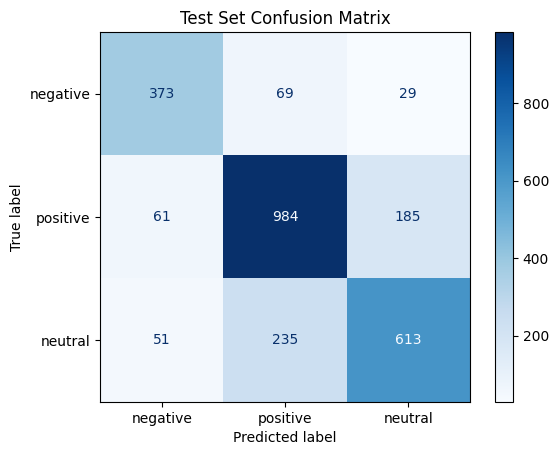

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ─── 2) Compute Predictions on Test Set ────────────────────────────────────
y_true_test, y_pred_test = [], []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = {
            "input_ids":      batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
        }
        logits = model(**inputs).logits
        preds  = logits.argmax(dim=-1).cpu().tolist()

        y_pred_test.extend(preds)
        y_true_test.extend(batch["labels"].tolist())

# ─── 3) Plot Confusion Matrix ───────────────────────────────────────────────
labels = ["negative", "positive", "neutral"]  # match your label2id order
cm = confusion_matrix(y_true_test, y_pred_test, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.show()

### **Evaluation - Baseline vs. LoRA Evaluation**

This cell compares the performance of the original (baseline) ProsusAI/finbert model against your LoRA-tuned version on the held-out test set.

1. **Imports & Configuration**  
   - Standard libraries for numerical ops (`numpy`) and PyTorch (`torch`).  
   - `sklearn` metrics: accuracy, F1, confusion matrix, classification report.  
   - Hugging Face’s `AutoModelForSequenceClassification` to load the baseline model.  
   - A fixed `LABEL_LIST` mapping integer IDs to human-readable sentiment labels.

2. **`evaluate()` Helper**  
   - Puts the model in evaluation mode.  
   - Iterates over a DataLoader, moves inputs to the appropriate device, and collects logits.  
   - Returns two lists: true labels and predicted labels.

3. **Baseline Model Evaluation**  
   - Loads `ProsusAI/finbert` with a sequence‐classification head (no LoRA adapter).  
   - Runs `evaluate()` on the test loader to get `true_lbls_base` / `pred_lbls_base`.

4. **LoRA-Tuned Model Evaluation**  
   - Uses your PEFT-wrapped `model` (already LoRA-fine-tuned).  
   - Runs `evaluate()` again to obtain `true_lbls_lora` / `pred_lbls_lora`.  
   - Asserts that the true labels are identical for both runs.

5. **Printing Standard Metrics**  
   - Defines `print_metrics(name, y_true, y_pred)` to display:  
     - Accuracy (%), weighted F1 (%).  
     - Confusion matrix.  
     - Detailed classification report with precision/recall/F1 per class.  
   - Calls it for both “Baseline” and “LoRA-tuned”.

6. **Side-by-Side Summary Table**  
   - Computes and prints a simple table comparing accuracy and weighted F1 between baseline and LoRA.

7. **Bootstrap Confidence Intervals**  
   - Runs 500 bootstrap resamplings to estimate the mean ± SD of accuracy and weighted F1 for each model.  
   - Prints 95% CI approximations for both baseline and LoRA models.

---

**Outcome:**  
You’ll end up with a clear quantitative comparison showing how much your LoRA adapter improved (or didn’t improve) sentiment‐classification performance over the vanilla FinBERT base.


In [16]:
# %% Cell X — Baseline vs LoRA Evaluation
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import AutoModelForSequenceClassification

LABEL_LIST = ["negative", "positive", "neutral"]
NUM_LABELS = len(LABEL_LIST)

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs = {
                "input_ids":      batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
            }
            labels = batch["labels"].to(device)
            logits = model(**inputs).logits
            preds  = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    return all_labels, all_preds

# 1) Baseline (no LoRA) model
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=NUM_LABELS
).to(device)
baseline_model.config.use_cache = False

true_lbls_base, pred_lbls_base = evaluate(baseline_model, test_loader, device)

# 2) LoRA‐tuned model (your PEFT model, already in `model`)
true_lbls_lora, pred_lbls_lora = evaluate(model, test_loader, device)
# (true labels should match)
assert true_lbls_base == true_lbls_lora

# 3) Print standard metrics
def print_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred) * 100
    f1  = f1_score(    y_true, y_pred, average="weighted") * 100
    print(f"— {name} —")
    print(f"Accuracy: {acc:5.2f}%   |   F1 (wtd): {f1:5.2f}%")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=LABEL_LIST, zero_division=0))
    print()

print_metrics("Baseline", true_lbls_base, pred_lbls_base)
print_metrics("LoRA-tuned", true_lbls_lora, pred_lbls_lora)

# 4) Side‐by‐side summary
acc_base = accuracy_score(true_lbls_base, pred_lbls_base)*100
acc_lora = accuracy_score(true_lbls_lora,  pred_lbls_lora)*100
f1_base  = f1_score(true_lbls_base,     pred_lbls_base, average="weighted")*100
f1_lora  = f1_score(true_lbls_lora,      pred_lbls_lora, average="weighted")*100

print("Summary │  Baseline │ LoRA-tuned")
print("─────────┼───────────┼──────────")
print(f"Acc     │   {acc_base:5.2f}%   │   {acc_lora:5.2f}%")
print(f"F1 (wtd)│   {f1_base:5.2f}%   │   {f1_lora:5.2f}%\n")

# 5) Bootstrap 95% CIs for both
n_boot = 500
rng    = np.random.RandomState(42)
accs_b, accs_l = [], []
f1s_b, f1s_l   = [], []

for _ in range(n_boot):
    idxs = rng.choice(len(true_lbls_base), len(true_lbls_base), replace=True)
    t    = [true_lbls_base[i] for i in idxs]
    pb   = [pred_lbls_base[i] for i in idxs]
    pl   = [pred_lbls_lora[i]  for i in idxs]
    accs_b.append(accuracy_score(t, pb))
    accs_l.append(accuracy_score(t, pl))
    f1s_b.append(f1_score(t, pb, average="weighted"))
    f1s_l.append(f1_score(t, pl, average="weighted"))

def ci(vals):
    m, s = np.mean(vals)*100, np.std(vals)*100
    return f"{m:5.2f}% ± {s:5.2f}%"

print(f"Bootstrap ({n_boot} iters)  │  Baseline         │ LoRA-tuned")
print(f"Accuracy CI              │  {ci(accs_b)}   │  {ci(accs_l)}")
print(f"F1 (wtd) CI              │  {ci(f1s_b)}   │  {ci(f1s_l)}")

— Baseline —
Accuracy: 35.15%   |   F1 (wtd): 22.65%
Confusion Matrix:
[[   7  238  226]
 [ 126   43 1061]
 [  10   25  864]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.05      0.01      0.02       471
    positive       0.14      0.03      0.06      1230
     neutral       0.40      0.96      0.57       899

    accuracy                           0.35      2600
   macro avg       0.20      0.34      0.22      2600
weighted avg       0.21      0.35      0.23      2600


— LoRA-tuned —
Accuracy: 75.77%   |   F1 (wtd): 75.67%
Confusion Matrix:
[[373  69  29]
 [ 61 984 185]
 [ 51 235 613]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.79      0.78       471
    positive       0.76      0.80      0.78      1230
     neutral       0.74      0.68      0.71       899

    accuracy                           0.76      2600
   macro avg       0.76      0.76      0.76      2600
w